# Community Event-Drug recovery

The dataset contains records of patients who had undertaken an experiment drug for a certain disease. We will have to find how each attribute is affecting the days to recover column.

Each person's age, gender, city, bmi (body-mass-index), sleep (in hours) was recorded, along with days to recovery.

The problem statement we seek to address here is to find which among the attributes age, gender, city, bmi, sleep, might affect the days to recover.

Appropriate hypothesis test needs to be done with a significance level of 0.05.

Basic exploratory data analysis and data cleaning is expected to be done before submitting the solution.

The submission should be solution.csv which is expected to have two columns: feature and relevance.
Feature will have age, gender, city, bmi, sleep.
Relevance will be 0 or 1 for each of the feature.

In [1]:
# Importing the libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
os.listdir('/kaggle/input')

['community-event-drug-recovery']

In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/community-event-drug-recovery/drug_recovery.csv')
df.head(10)

,city,gender,age,bmi,sleep,days
0,mumbai,Male,60.0,20.18,6.74,15.52
1,mumbai,Female,51.0,20.25,9.00,18.19
2,Bangalore,Female,25.0,20.57,8.47,16.32
3,Mumbai,Female,33.0,20.25,8.43,16.70
4,mumbai,Male,67.0,20.63,8.23,16.77
5,Mumbai,Female,52.0,21.67,8.60,20.82
6,Mumbai,Female,48.0,22.51,6.33,14.00
7,Mumbai,Male,51.0,19.08,5.44,19.24
8,Mumbai,Male,36.0,18.56,8.96,18.87
9,bangalore,female,57.0,19.86,8.76,16.07


In [4]:
# Checking the shape of the data
df.shape

(10000, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    10000 non-null  object 
 1   gender  10000 non-null  object 
 2   age     9908 non-null   float64
 3   bmi     10000 non-null  float64
 4   sleep   10000 non-null  float64
 5   days    10000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 468.9+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,9908.0,50.562071,44.020977,18.00,32.00,47.00,61.00,550.00
bmi,10000.0,21.676711,1.866919,18.50,20.05,21.67,23.28,24.90
sleep,10000.0,6.999622,1.173446,5.00,5.97,6.98,8.03,9.00
days,10000.0,15.770061,2.579236,10.02,13.92,15.55,17.49,23.99


	It appears that the city names do not adhere to a consistent camel case format. Therefore, we should standardize the capitalization of the city names.

In [7]:
# Make the string entries uniform

df.city = df.city.str.capitalize()
df.gender = df.gender.str.capitalize()

In [8]:
df.describe(include=object).T

,count,unique,top,freq
city,10000,2,Mumbai,5054
gender,10000,2,Male,5049


In [9]:
# Check nulls (% of missing values)
df.isna().sum()/len(df)

city      0.0000
gender    0.0000
age       0.0092
bmi       0.0000
sleep     0.0000
days      0.0000
dtype: float64

	Very few records are missing, so let's drop them


In [10]:
# Drop Missing values
df = df.dropna()
df.shape

(9908, 6)

In [11]:
df.describe(include='object').T

,count,unique,top,freq
city,9908,2,Mumbai,5009
gender,9908,2,Male,5002


In [12]:
def numerical_plot(col_name):
    plt.subplots(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(df[col_name], color='black')
    plt.title(f"{col_name}")
    plt.subplot(122)
    ax = sns.boxplot(y=df[col_name], showfliers=False)
    ax.axhline(df[col_name].median(), color='r', linestyle='--')
    plt.title(f"Boxplot of {col_name}")
    plt.tight_layout(pad=3)
            

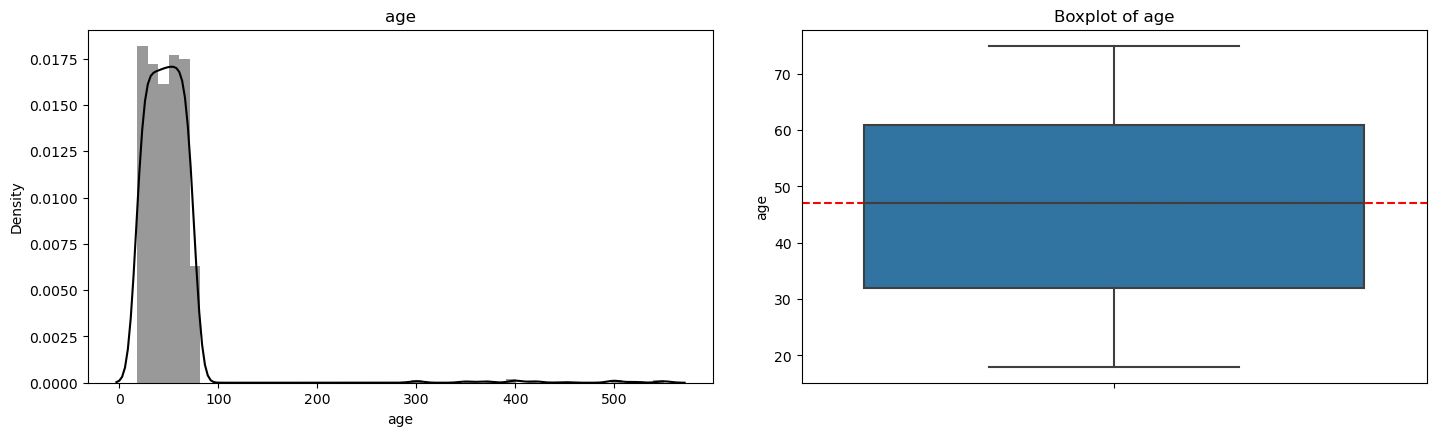

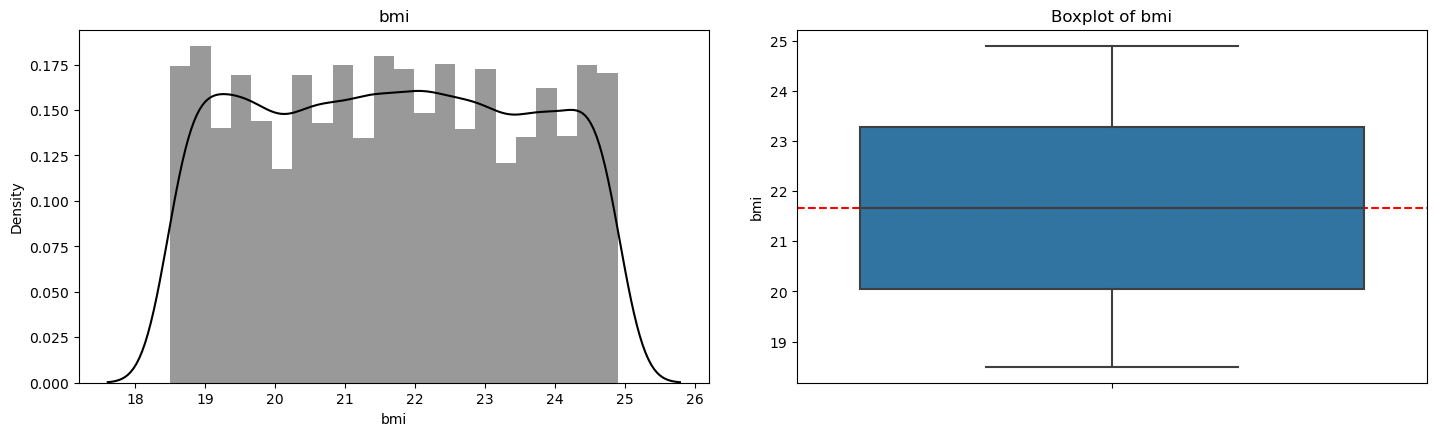

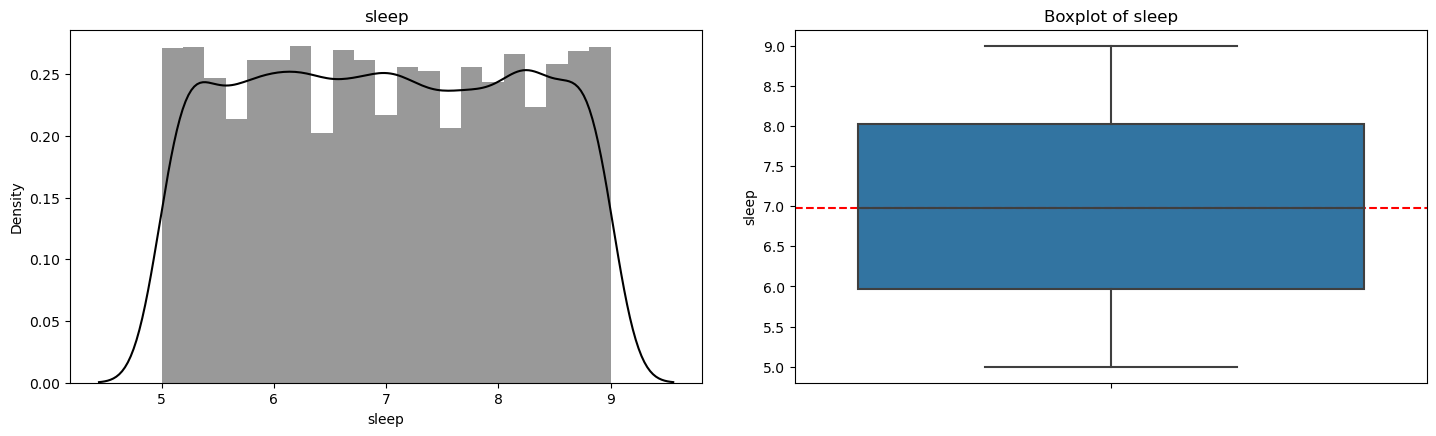

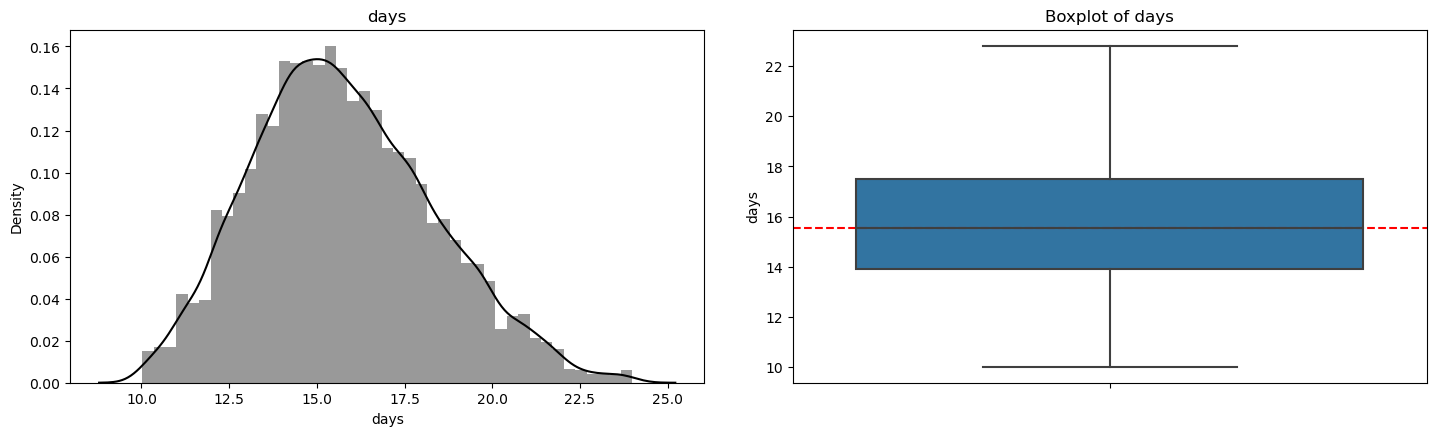

In [13]:
num_cols = df.keys()[(df.dtypes!='object').values]
for i in num_cols:
    numerical_plot(i)

In [14]:
df.loc[df['age'] > 75, 'age'].min(), df.loc[df['age'] > 75, 'age'].max()

(300.0, 550.0)

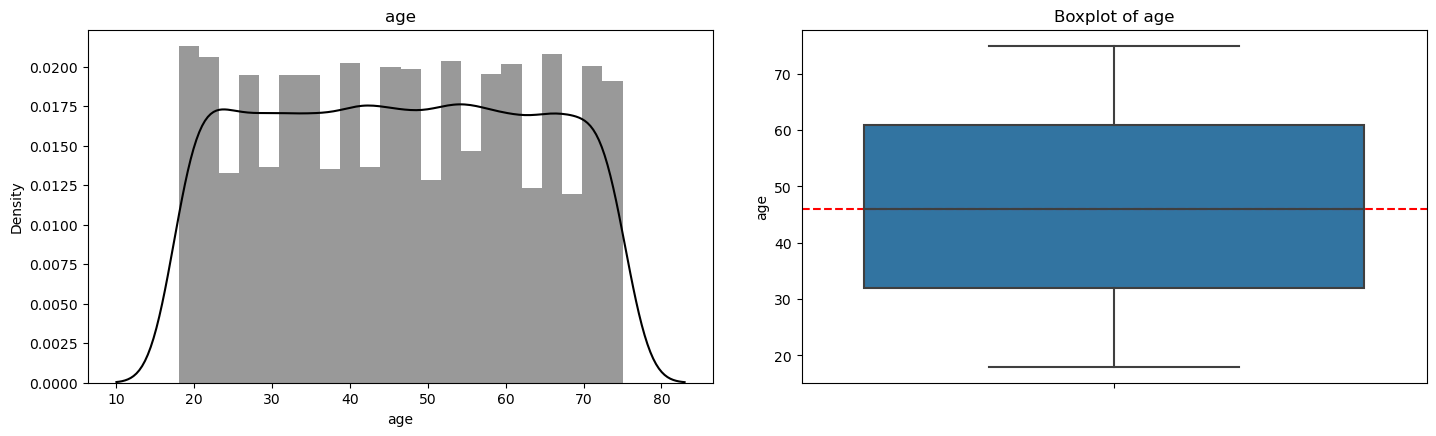

In [15]:
# Outliers treatment for Age

df.loc[df['age'] > 75, 'age'] /= 10
numerical_plot('age')

In [16]:
df.age.describe()

count    9908.000000
mean       46.277352
std        16.727040
min        18.000000
25%        32.000000
50%        46.000000
75%        61.000000
max        75.000000
Name: age, dtype: float64

#### Insights:

	1. The distribution is not gaussian, so we'll have to go with non-parametric hypothesis tests
    2. After conducting a more thorough analysis of the outlier values for Age, it was discovered that there were additional zeros present. As a solution, the values were divided by 10.

In [17]:
## Value counts

for i in num_cols:
    print(i,'-', df[i].nunique())

age - 58
bmi - 100
sleep - 100
days - 1246


In [18]:
num_cols

Index(['age', 'bmi', 'sleep', 'days'], dtype='object')

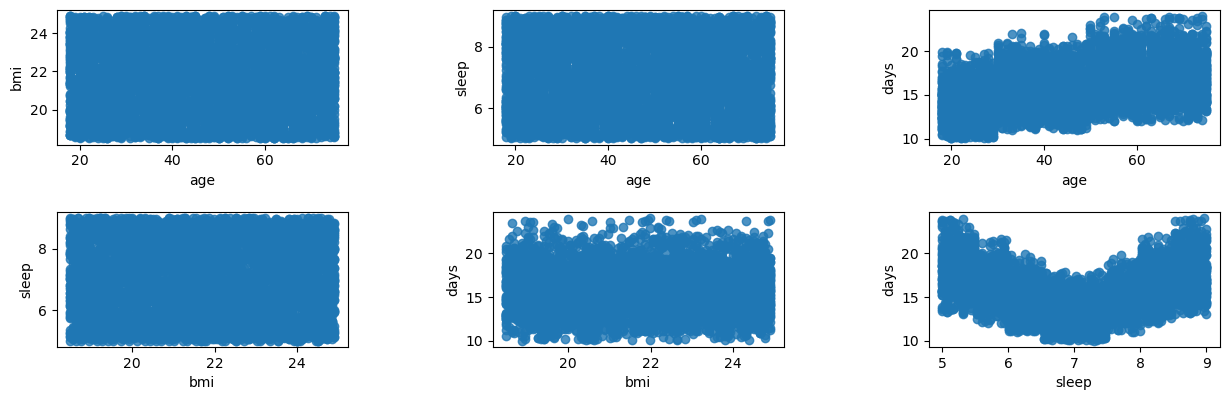

In [19]:

plt.figure(1 , figsize = (15 , 7))
n = 0 
for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        
        if(j>i):
            n += 1
            plt.subplot(3 , 3 , n)
            plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
            sns.regplot(x = col1 , y = col2 , data = df.sample(frac=0.5, random_state=42))
            plt.ylabel(col2.split()[0]+' '+col2.split()[1] if len(col2.split()) > 1 else col2 )

# Show the plot
plt.show()

	It seems Age and Sleep have some relation to days to recover.

### Hypothesis-Test

In [20]:
# Count the number of males and females
male_count = len(df.loc[df['gender']=='Male'])
female_count = len(df.loc[df['gender']=='Female'])

# Check if the sample sizes are equal
if male_count == female_count:
    print('The sample sizes for males and females are equal.')
else:
    print(f'The sample sizes for males and females are unequal --> {male_count}:{female_count}')

# Count the number of patients in each city
city1_count = len(df.loc[df['city']=='Mumbai'])
city2_count = len(df.loc[df['city']=='Bangalore'])

# Check if the sample sizes are equal
if city1_count == city2_count:
    print('The sample sizes for City1 and City2 are equal.')
else:
    print(f'The sample sizes for City1 and City2 are unequal --> {city1_count}:{city2_count}')


The sample sizes for males and females are unequal --> 5002:4906
The sample sizes for City1 and City2 are unequal --> 5009:4899


In [21]:
# T-test for gender
male_days = df.loc[df['gender']=='Male', 'days'].sample(4906)
female_days = df.loc[df['gender']=='Female', 'days']
print(len(male_days), len(female_days))
t_stat, p_value_gender = stats.ttest_ind(male_days, female_days)
if p_value_gender < 0.05:
    print('The mean days to recover is significantly different between males and females.')
else:
    print('There is no significant difference in the mean days to recover between males and females.')

# T-test for city
city1_days = df.loc[df['city']=='Mumbai', 'days']
city2_days = df.loc[df['city']=='Bangalore', 'days'].sample(4899)
t_stat, p_value_city = stats.ttest_ind(city1_days, city2_days)
if p_value_city < 0.05:
    print('The mean days to recover is significantly different between the two cities.')
else:
    print('There is no significant difference in the mean days to recover between the two cities.')

# Correlation test for age
age = df['age']
days = df['days']
corr, p_value_age = stats.pearsonr(age, days)
if p_value_age < 0.05:
    print('There is a significant correlation between age and days to recover.')
else:
    print('There is no significant correlation between age and days to recover.')

# Correlation test for BMI
bmi = df['bmi']
corr, p_value_bmi = stats.pearsonr(bmi, days)
if p_value_bmi < 0.05:
    print('There is a significant correlation between BMI and days to recover.')
else:
    print('There is no significant correlation between BMI and days to recover.')

# Correlation test for sleep
sleep = df['sleep']
corr, p_value_sleep = stats.pearsonr(sleep, days)
if p_value_sleep < 0.05:
    print('There is a significant correlation between sleep and days to recover.')
else:
    print('There is no significant correlation between sleep and days to recover.')


4906 4906
There is no significant difference in the mean days to recover between males and females.
The mean days to recover is significantly different between the two cities.
There is a significant correlation between age and days to recover.
There is no significant correlation between BMI and days to recover.
There is no significant correlation between sleep and days to recover.


### Since the distribution is not normal, so trying non-parametric tests

##### 1. Kendall's tau correlation

In [22]:
# Correlation test for age
age = df['age']
days = df['days']
corr, p_value_age = stats.kendalltau(age, days)
if p_value_age < 0.05:
    print('There is a significant correlation between age and days to recover.')
else:
    print('There is no significant correlation between age and days to recover.')

# Correlation test for BMI
bmi = df['bmi']
corr, p_value_bmi = stats.kendalltau(bmi, days)
if p_value_bmi < 0.05:
    print('There is a significant correlation between BMI and days to recover.')
else:
    print('There is no significant correlation between BMI and days to recover.')

# Correlation test for sleep
sleep = df['sleep']
corr, p_value_sleep = stats.kendalltau(sleep, days)
if p_value_sleep < 0.05:
    print('There is a significant correlation between sleep and days to recover.')
else:
    print('There is no significant correlation between sleep and days to recover.')


There is a significant correlation between age and days to recover.
There is no significant correlation between BMI and days to recover.
There is no significant correlation between sleep and days to recover.


##### 2. Spearman's correlation

In [23]:
# Correlation test for age
age = df['age']
days = df['days']
corr, p_value_age = stats.spearmanr(age, days)
if p_value_age < 0.05:
    print('There is a significant correlation between age and days to recover.')
else:
    print('There is no significant correlation between age and days to recover.')

# Correlation test for BMI
bmi = df['bmi']
corr, p_value_bmi = stats.spearmanr(bmi, days)
if p_value_bmi < 0.05:
    print('There is a significant correlation between BMI and days to recover.')
else:
    print('There is no significant correlation between BMI and days to recover.')

# Correlation test for sleep
sleep = df['sleep']
corr, p_value_sleep = stats.spearmanr(sleep, days)
if p_value_sleep < 0.05:
    print('There is a significant correlation between sleep and days to recover.')
else:
    print('There is no significant correlation between sleep and days to recover.')


There is a significant correlation between age and days to recover.
There is no significant correlation between BMI and days to recover.
There is no significant correlation between sleep and days to recover.


	We saw sleep has some relation to recovery time
	Let's change sleep hours to bin and perform ANOVA test on it

In [24]:
# define the bin edges
bins = [5, 6, 7, 8, 9]

# define the bin labels
labels = ['5-6', '6-7', '7-8', '8-9']

# use pandas.cut() to create the bins
df['sleep_bins'] = pd.cut(df['sleep'], bins=bins, labels=labels)

# perform one-way ANOVA
f_val, p_value_sleep = stats.f_oneway(df[df['sleep_bins'] == '5-6']['days'], 
                              df[df['sleep_bins'] == '6-7']['days'],
                              df[df['sleep_bins'] == '7-8']['days'],
                              df[df['sleep_bins'] == '8-9']['days'])

# print the ANOVA results
print("One-way ANOVA results:")
print("F value: ", f_val)
print("p value: ", p_value_sleep)

if p_value_sleep < 0.05:
    print('There is a significant correlation between age and days to recover.')
else:
    print('There is no significant correlation between age and days to recover.')


One-way ANOVA results:
F value:  1748.3831901683664
p value:  0.0
There is a significant correlation between age and days to recover.


In [25]:
## Creating Submission file in csv (as per requirements)

In [26]:
# Dictionary to store feature relevance
feature_relevance = {'gender': 0, 'city': 0, 'age': 0, 'bmi': 0, 'sleep': 0}


In [27]:
if p_value_gender < 0.05:
    feature_relevance['gender'] = 1

if p_value_city < 0.05:
    feature_relevance['city'] = 1

if p_value_age < 0.05:
    feature_relevance['age'] = 1

if p_value_bmi < 0.05:
    feature_relevance['bmi'] = 1

if p_value_sleep < 0.05:
    feature_relevance['sleep'] = 1


In [28]:
import csv

with open('solution.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['feature', 'relevance'])
    for feature, relevance in feature_relevance.items():
        writer.writerow([feature, relevance])
